In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(rc={'figure.figsize':(11.7,8.27)}, style='darkgrid')

from warnings import filterwarnings
filterwarnings('ignore')

pd.set_option("display.max_columns", 36)

In [2]:
df = pd.read_csv("palm_ffb.csv")

In [3]:
df.head()

,Date,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield
0,01.01.2008,616.4,25.306452,21.3,32.2,184.4,25,777778.3951,1.62
1,01.02.2008,568.9,26.165517,20.9,35.1,140.2,23,767988.2759,1.45
2,01.03.2008,577.6,25.448387,21.3,32.9,280.4,25,783951.9231,1.56
3,01.04.2008,581.1,26.903333,20.6,34.8,173.3,25,788987.0504,1.39
4,01.05.2008,545.4,27.241935,20.9,35.0,140.6,25,813659.7222,1.44


In [4]:
# Find out the number of rows & features in the dataset
df.shape

(130, 9)

In [5]:
# A quick glance on the data's characteristics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           130 non-null    object 
 1   SoilMoisture   130 non-null    float64
 2   Average_Temp   130 non-null    float64
 3   Min_Temp       130 non-null    float64
 4   Max_Temp       130 non-null    float64
 5   Precipitation  130 non-null    float64
 6   Working_days   130 non-null    int64  
 7   HA_Harvested   130 non-null    float64
 8   FFB_Yield      130 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 9.3+ KB


In [6]:
# Create new features based on existing ones
df["Total FFB"] = df["FFB_Yield"] * df["HA_Harvested"]
df["Total FFB per Working Day"] = df["Total FFB"] / df["Working_days"]

In [7]:
# Convert the date to a datetime object
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')

In [8]:
df.head()

,Date,SoilMoisture,Average_Temp,Min_Temp,Max_Temp,Precipitation,Working_days,HA_Harvested,FFB_Yield,Total FFB,Total FFB per Working Day
0,2008-01-01,616.4,25.306452,21.3,32.2,184.4,25,777778.3951,1.62,1.260001e+06,50400.040002
1,2008-02-01,568.9,26.165517,20.9,35.1,140.2,23,767988.2759,1.45,1.113583e+06,48416.652176
2,2008-03-01,577.6,25.448387,21.3,32.9,280.4,25,783951.9231,1.56,1.222965e+06,48918.600001
3,2008-04-01,581.1,26.903333,20.6,34.8,173.3,25,788987.0504,1.39,1.096692e+06,43867.680002
4,2008-05-01,545.4,27.241935,20.9,35.0,140.6,25,813659.7222,1.44,1.171670e+06,46866.799999


In [9]:
# Create Pearson Correlation Matrix on FFB_Yield feature
corr = df.corr()['FFB_Yield'].sort_values(ascending=False)[1:]
corr

Total FFB                    0.971782
Total FFB per Working Day    0.934225
Precipitation                0.289604
Working_days                 0.116364
Min_Temp                     0.103830
SoilMoisture                -0.003183
Average_Temp                -0.005494
Max_Temp                    -0.071201
HA_Harvested                -0.350222
Name: FFB_Yield, dtype: float64

Correlation value for **FFB_Yield** was plotted against other features. Features like **Total FFB** & **Total FFB per Working Day** & **HA_Harvested** was ignored to avoid multicollinearity issue. **Precipitation** was found out to be has high correlation with **FFB_Yield**.

<AxesSubplot:xlabel='Date', ylabel='Precipitation'>

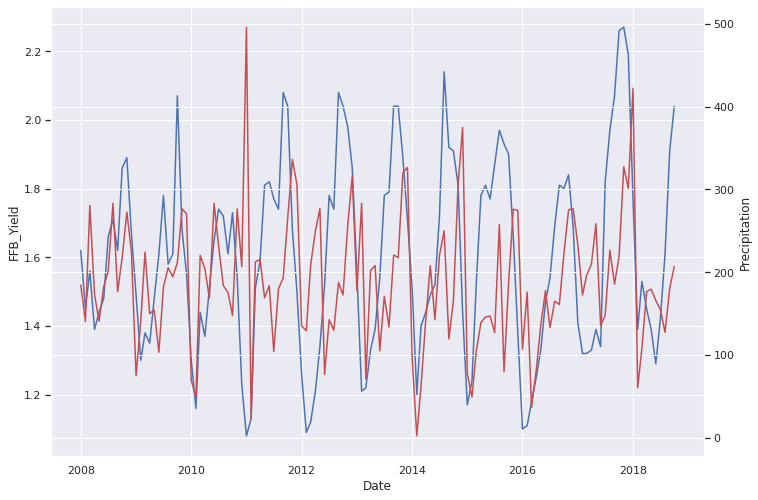

In [10]:
sns.lineplot(x="Date", y="FFB_Yield", data=df, color='b')
ax2 = plt.twinx()
sns.lineplot(x="Date", y="Precipitation", data=df, color='r', ax=ax2)

Apparently, **FFB_Yield** moves in line with precipitation. Based on the graph above, the yield was fluctuated & seems to drop in the 1st quarter of every year (Jan-March). The water-limited yield is an important benchmark as most of the oil palm cropping systems are rain-fed. Yield reduced if rainfail less than 2000 mm/yr or more than 3500 mm/yr and/or less than 100 mm/yr ([Yield gaps in oil palm: A quantitative review of contributing factors](https://reader.elsevier.com/reader/sd/pii/S1161030116302131?token=C26C735E785F32E0207E3A09E2A3DCD8E9F5350B4670E5D23EF888EF992F21301F374C1359FD5CFA350550E9746918A0&originRegion=eu-west-1&originCreation=20220614155939)).

In [11]:
corr = df.corr()['Precipitation'].sort_values(ascending=False)[1:]
corr

SoilMoisture                 0.552001
Min_Temp                     0.345944
FFB_Yield                    0.289604
Total FFB                    0.232475
Total FFB per Working Day    0.195985
Working_days                 0.127897
HA_Harvested                -0.265866
Average_Temp                -0.369386
Max_Temp                    -0.461117
Name: Precipitation, dtype: float64

Eventually, **Precipitation** has high correlation with **SoilMoisture** as soil water availability depends on the influx of water (rainfall, irrigation, and groundwater), the loss of water (evapotranspiration, drainage, and surface water run-off), and the previous soil water reserve. Precipitation had effects on soil moisture in about 91% in a study ([Quantifying the Effects of Climate and Vegetation
on Soil Moisture in an Arid Area, China](https://www.mdpi.com/2073-4441/11/4/767/pdf#:~:text=soil%20moisture%20variability.-,Precipitation%20had%20effects%20on%20soil%20moisture%20in%20about%2091%25%20of,87%25%20of%20the%20study%20area.)).

In [12]:
data_copy = df.copy()

In [13]:
data_copy.set_index('Date', inplace=True)

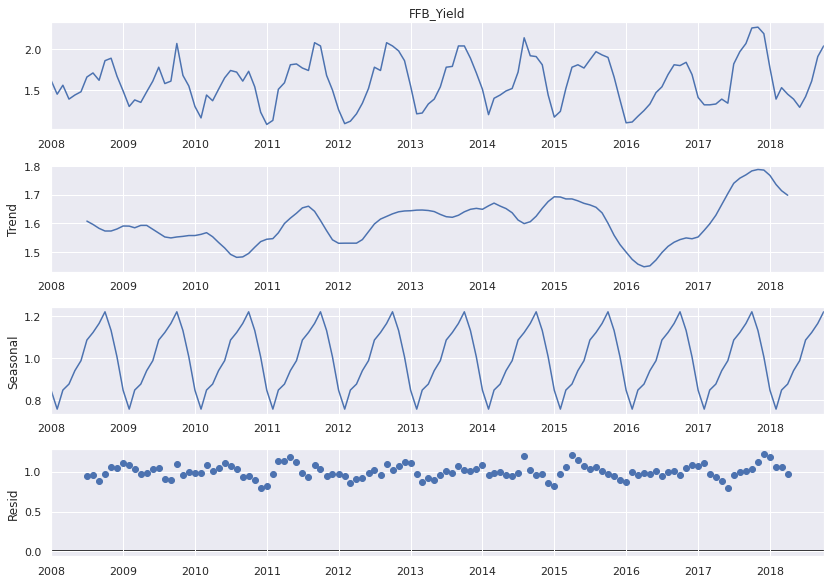

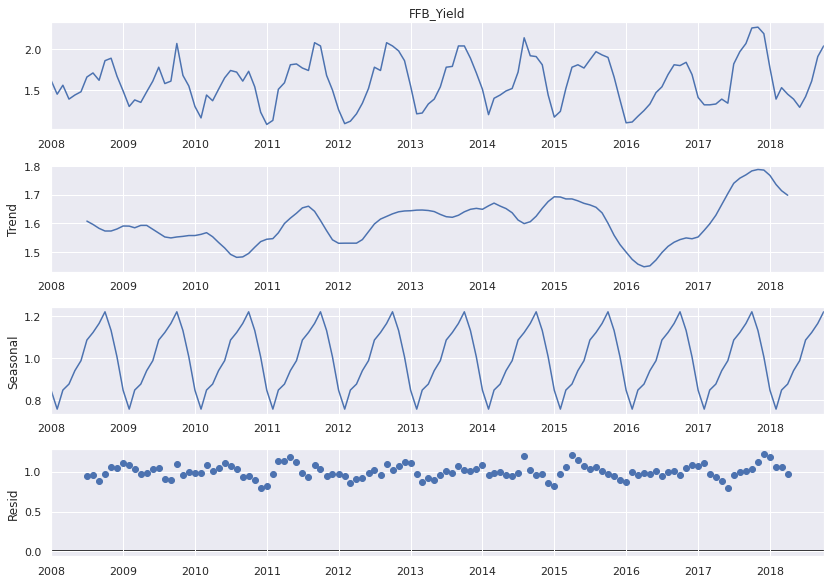

In [14]:
decompose_result_mult = seasonal_decompose(data_copy['FFB_Yield'], model="multiplicative")
decompose_result_mult.plot()


Seasonal decompose was also executed on **FFB_Yield** datapoints to seperate seasonality & trend. We have observed that there was a sudden drop of FFB yield in 2016 due to El Nino. For the full year of 2016, Malaysia’s total palm oil production fell 13.2% to 17.32 million tonnes, from 19.96 million tonnes in 2015, due to lingering effects of the 2015 El Nino weather phenomenon which affected oil yields ([Palm oil production down 13.2% in 2016 on after-effects of El Nino](https://www.theedgemarkets.com/article/palm-oil-production-down-132-2016-after-effects-el-nino)). 

In [15]:
df_ordered = df.copy()

df_ordered['Month'] = df_ordered['Date'].dt.month_name().str[:3]

In [16]:
ordered_months = df_ordered['Date'].dt.month_name().str[:3].unique()

df_ordered['Month'] = pd.Categorical(df_ordered["Month"], 
    categories=ordered_months, 
    ordered=True)


Text(0, 0.5, 'FFB Yield (Tonnes/Hectares)')

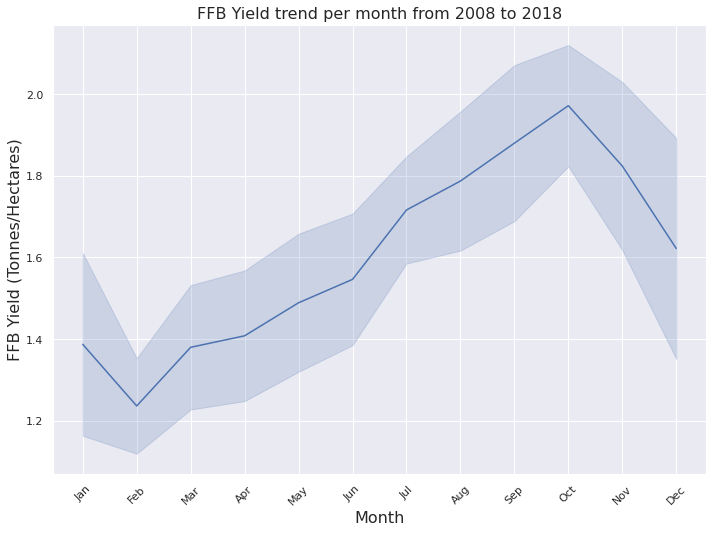

In [17]:
sns.lineplot(x = "Month", y="FFB_Yield", data=df_ordered
            , palette="dark", ci='sd')
plt.title("FFB Yield trend per month from 2008 to 2018", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.xticks(rotation=45)
plt.ylabel("FFB Yield (Tonnes/Hectares)", fontsize=16)


Based on the graph above, obviously for from year 2008 to 2018, FFB yield is the highest in October & the lowest in February.

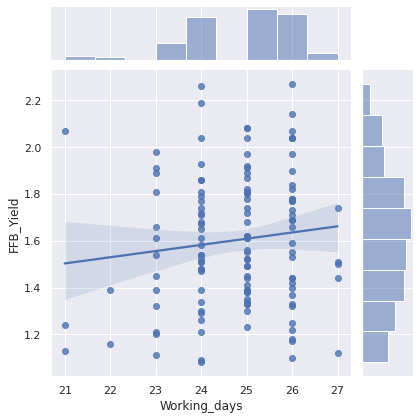

In [18]:
sns.jointplot(df['Working_days'], df['FFB_Yield'], kind='reg')

Between working days & FFB Yield, there is a slight positive correlation. FFB need to be harvested & performed any other maintenaince on it during working days. Beside harvesting, worers also need to apply fertiliser, clear overgrowth or remove decaying fronds from the trees ([Malaysia’s palm oil yield to continue declining on labour shortage](https://www.theedgemarkets.com/article/malaysias-palm-oil-yield-continue-declining-labour-shortage)). Eventhough not necessarily, high working days do increase FFB yield.